# DEA CoastLines vector statistics

## To do:
* [X] Update for 2019


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_statistics as deacl_stats

import os
import sys
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import array_bounds
import pandas as pd
import shutil
import matplotlib.pyplot as plt


## Load in data

In [17]:
# Read in contours
study_area = 1169
output_name = 'v0.3.0'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2019'


## Load DEA CoastLines rasters

In [18]:
yearly_ds, gapfill_ds = deacl_stats.load_rasters(output_name, 
                                                 study_area, 
                                                 water_index)
print(yearly_ds)

# Create output vector folder
output_dir = f'output_data/{study_area}_{output_name}/vectors'
os.makedirs(f'{output_dir}/shapefiles', exist_ok=True)

<xarray.Dataset>
Dimensions:  (x: 2115, y: 1535, year: 32)
Coordinates:
  * year     (year) int64 1988 1989 1990 1991 1992 ... 2015 2016 2017 2018 2019
  * x        (x) float64 4.930e+05 4.931e+05 4.931e+05 ... 5.564e+05 5.565e+05
  * y        (y) float64 -2.27e+06 -2.27e+06 ... -2.316e+06 -2.316e+06
Data variables:
    mndwi    (year, y, x) float32 0.65540683 0.5893762 ... -0.54783356
    tide_m   (year, y, x) float32 0.043983646 0.043982517 ... -0.17851853
    count    (year, y, x) int16 14 14 14 14 14 14 14 14 ... 19 19 20 20 19 19 19
    stdev    (year, y, x) float32 0.24404566 0.19468887 ... 0.043214124
Attributes:
    transform:      | 30.00, 0.00, 493035.00|\n| 0.00,-30.00,-2270445.00|\n| ...
    crs:            +init=epsg:32650
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


## Load vector data

In [19]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Rocky shore mask
smartline_gdf = (gpd.read_file('input_data/Smartline.gdb', 
                               bbox=bbox).to_crs(yearly_ds.crs))

# Tide points
points_gdf = (gpd.read_file('input_data/tide_points_coastal.geojson', 
                            bbox=bbox).to_crs(yearly_ds.crs))

# Study area polygon
comp_gdf = (gpd.read_file('input_data/50km_albers_grid_clipped.geojson', 
                          bbox=bbox)
            .set_index('id')
            .to_crs(str(yearly_ds.crs)))

# Mask to study area
study_area_poly = comp_gdf.loc[study_area]

# Load climate indices
climate_df = pd.read_csv('input_data/climate_indices.csv', index_col='year')

## Extract shoreline contours

### Extract ocean-masked contours

In [20]:
# Generate waterbody mask
waterbody_array = deacl_stats.waterbody_mask(
    input_data='input_data/SurfaceHydrologyPolygonsRegional.gdb',
    modification_data='input_data/estuary_mask_modifications.geojson',
    bbox=bbox,
    yearly_ds=yearly_ds)

In [21]:
# Mask dataset to focus on coastal zone only
masked_ds = deacl_stats.contours_preprocess(
    yearly_ds,
    gapfill_ds,
    water_index,
    index_threshold,
    waterbody_array,
    points_gdf,
    output_path=f'output_data/{study_area}_{output_name}')

In [22]:
# Extract contours
contours_gdf = (deacl_stats.subpixel_contours(da=masked_ds,
                                              z_values=index_threshold,
                                              min_vertices=30,
                                              dim='year',
                                              output_path='temp.geojson')
                .set_index('year'))

Operating in single z-value, multiple arrays mode
Writing contours to temp.geojson


## Compute statistics
### Create stats points on baseline contour

In [ ]:
# Extract statistics modelling points along baseline contour
points_gdf = deacl_stats.points_on_line(contours_gdf, 
                                        baseline_year, 
                                        distance=30)

# Clip to remove rocky shoreline points
points_gdf = deacl_stats.rocky_shores_clip(points_gdf, 
                                           smartline_gdf, 
                                           buffer=50)


### Measure annual coastline movements

In [ ]:
if points_gdf is not None:
    
    # Make a copy of the points GeoDataFrame to hold tidal data
    tide_points_gdf = points_gdf.copy()

    # Calculate annual movements and residual tide heights for every contour
    # compared to the baseline year
    points_gdf, tide_points_gdf = deacl_stats.annual_movements(yearly_ds, 
                                                               points_gdf, 
                                                               tide_points_gdf, 
                                                               contours_gdf, 
                                                               baseline_year,
                                                               water_index)

### Calculate regressions

In [ ]:
if points_gdf is not None:

    points_gdf = deacl_stats.calculate_regressions(contours_gdf, 
                                                   points_gdf, 
                                                   tide_points_gdf, 
                                                   climate_df)
    
# Add in retreat/growth helper columns (used for web services)
points_gdf['retreat'] = points_gdf.rate_time < 0 
points_gdf['growth'] = points_gdf.rate_time > 0

# Add Shoreline Change Envelope (SCE), Net Shoreline 
# Movement (NSM) and Max/Min years
points_gdf[['sce', 'nsm', 'max_year', 'min_year']] = points_gdf.apply(
    lambda x: deacl_stats.all_time_stats(x), axis=1)

## Export files

### Export stats files

In [ ]:
if points_gdf is not None:
    
    # Set up scheme to optimise file size
    schema_dict = {key: 'float:8.2' for key in points_gdf.columns
                   if key != 'geometry'}
    schema_dict.update({'sig_time': 'float:8.3',
                        'outl_time': 'str:80',
                        'retreat': 'bool', 
                        'growth': 'bool',
                        'max_year': 'int:4',
                        'min_year': 'int:4'})
    col_schema = schema_dict.items()

    # Clip stats to study area extent, remove rocky shores
    stats_path = f'{output_dir}/stats_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(study_area_poly['geometry'])]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    stats_path = stats_path.replace('vectors', 'vectors/shapefiles')
    points_gdf.to_file(f'{stats_path}.shp',
                       schema={'properties': col_schema,
                               'geometry': 'Point'})

In [25]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import topojson as tp
import geopandas as gpd
from scipy import stats
from affine import Affine
from shapely.geometry import shape
from shapely.geometry import box
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from shapely.ops import nearest_points
from rasterio.features import shapes
from rasterio.features import sieve
from rasterio.features import rasterize
from rasterio.transform import array_bounds
from skimage.measure import label
from skimage.measure import find_contours
from skimage.morphology import binary_opening
from skimage.morphology import binary_erosion
from skimage.morphology import binary_dilation
from skimage.morphology import disk, square
from datacube.utils.cog import write_cog


In [41]:

output_path=f'output_data/{study_area}_{output_name}'
uncertain_classes=[4, 5]

# Read data and restrict to uncertain vs certain classes
all_time_mask = xr.open_rasterio(f'{output_path}/all_time_mask.tif')
uncertain_array = all_time_mask.squeeze().drop('band').data.astype(np.int32)
uncertain_array[~np.isin(uncertain_array, uncertain_classes)] = 0

# Remove isolated pixels and vectorise data
uncertain_array = sieve(uncertain_array, size=3)
vectors = shapes(source=uncertain_array,
                 transform=all_time_mask.geobox.transform)

# Extract the polygon coordinates and values from the list
vectors = list(vectors)
polygons = [shape(polygon) for polygon, value in vectors]
values = [int(value) for polygon, value in vectors]

# Create a geopandas dataframe populated with the polygon shapes
vector_mask = gpd.GeoDataFrame(data={'certainty': values},
                               geometry=polygons,
                               crs=all_time_mask.geobox.crs)

# Dissolve by class and simplify features to remove hard pixel edges
topo = tp.Topology(vector_mask, prequantize=False)
vector_mask = topo.toposimplify(30).to_gdf()
vector_mask = vector_mask.dissolve('certainty')

In [61]:
import topojson as tp
import geopandas as gpd

# Read file
gdf = gpd.read_file('polygons.json')

# Construct topology and simplify
topo = tp.Topology(gdf, prequantize=False, winding_order='CCW_CW')
simplified_gdf = topo.toposimplify(30).to_gdf()

TypeError: 'NoneType' object is not iterable

In [59]:
simplified_gdf.crs = all_time_mask.crs
simplified_gdf.to_crs('EPSG:4326').to_file('polygons_fixed.json', driver='GeoJSON')

In [57]:
from __future__ import print_function
import fiona
import sys; print(sys.version)
import platform; print(platform.platform())
import skimage; print("topojson version: {}".format(tp.__version__))
import numpy; print("numpy version: {}".format(numpy.__version__))
import numpy; print("geopandas version: {}".format(gpd.__version__))
import numpy; print("fiona version: {}".format(fiona.__version__))

3.6.10 | packaged by conda-forge | (default, Apr 24 2020, 16:44:11) 
[GCC 7.3.0]
Linux-2.6.32-754.18.2.el6.x86_64-x86_64-with-centos-6.10-Final
topojson version: 1.0rc10
numpy version: 1.18.5
geopandas version: 0.7.0
fiona version: 1.8.13


In [43]:
vector_mask.crs = all_time_mask.crs

In [48]:
vector_mask.to_crs('EPSG:4326').to_file('polygons.json', driver='GeoJSON')

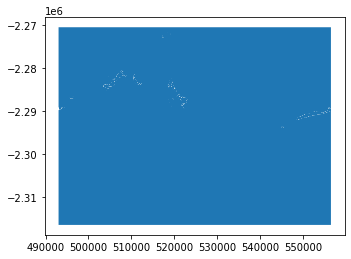

In [47]:
vector_mask

In [38]:
tp.Topology(vector_mask)

TypeError: 'NoneType' object is not iterable

In [35]:
list(vector_mask.geometry.buffer(0))

### Export contours

In [23]:
# Assign certainty to contours based on underlying masks
contours_gdf2 = deacl_stats.contour_certainty(
    contours_gdf, 
    output_path=f'output_data/{study_area}_{output_name}')

# # Clip annual shoreline contours to study area extent
# contour_path = f'{output_dir}/contours_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
# contours_gdf['geometry'] = contours_gdf.intersection(study_area_poly['geometry'])
# contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
#                                                        driver='GeoJSON')

# # Export stats and contours as ESRI shapefiles
# contour_path = contour_path.replace('vectors', 'vectors/shapefiles')
# contours_gdf.reset_index().to_file(f'{contour_path}.shp')

TypeError: 'NoneType' object is not iterable

## Generate continental summary layer

In [ ]:
from deacoastlines_summary import main

In [ ]:
main(['out', 'v0.3.0', '0.00', False])

## Merge contours and rasters

In [ ]:
# Export mask
!gdalwarp output_data/*v0.2.0/all_time_mask.tif mask_v0.2.0.tif -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024 -overwrite -q

In [ ]:
!gdalwarp output_data/*v0.2.0/1988_count.tif 1988_count.tif -co COMPRESS=DEFLATE -co ZLEVEL=5 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024 -overwrite -q

In [ ]:
!gdalwarp output_data/*v0.2.0/2011_mndwi.tif 2011_mndwi.tif -co COMPRESS=DEFLATE -co ZLEVEL=5 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024 -co BIGTIFF=YES -overwrite -q

In [ ]:
!gdaladdo -r average 1988_count.tif 16

## Assorted

In [ ]:
def gadi_su(memory, time, queue='normal'):
    
    if queue == 'normal':
        print((memory / 4) * 2 * time)
    if queue == 'hugemem':
        print((memory / 32) * 3 * time)
        
gadi_su(memory=96, time=6, queue='hugemem')        
        

In [ ]:
import shutil
shutil.make_archive('DEACoastLines_v0.2.0', 'zip', '/g/data/r78/rt1527/dea-notebooks/MAHTS/packages/DEACoastLines_v0.2.0')


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020